# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import json
import requests
import geopandas as gpd

from scipy.stats import zscore
from scipy.spatial import ConvexHull

from datetime import datetime
import time

from matplotlib import ticker
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import config_context
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE


# Analyzing and Cleaning the data

In [2]:
df = pd.read_csv('Crimes_2001_to_Present_20250419.csv')
chicago_map = gpd.read_file('chicago_police_districts.geojson')
pd.set_option('display.float_format', '{:.2f}'.format)
df['Year'] = df['Year'].apply(lambda x: '{:.0f}'.format(x))
df['Year'] = pd.to_numeric(df['Year'])
df['ID'] = df['ID'].apply(lambda x: '{:.0f}'.format(x))
df['Date'] = pd.to_datetime(df['Date'])
df['X Coordinate'] = pd.to_numeric(df['X Coordinate'], errors='coerce')
df['Y Coordinate'] = pd.to_numeric(df['Y Coordinate'], errors='coerce')

In [3]:
df.head()

ID Case Number                Date                    Block  IUCR  \
0  13311263    JG503434 2022-07-29 03:39:00          023XX S TROY ST  1582   
1  13053066    JG103252 2023-01-03 16:44:00  039XX W WASHINGTON BLVD  2017   
2  11227634    JB147599 2017-08-26 10:00:00      001XX W RANDOLPH ST  0281   
3  13203321    JG415333 2023-09-06 17:00:00         002XX N Wells st  1320   
4  13204489    JG416325 2023-09-06 11:00:00           0000X E 8TH ST  0810   

                 Primary Type                    Description  \
0  OFFENSE INVOLVING CHILDREN              CHILD PORNOGRAPHY   
1                   NARCOTICS  MANUFACTURE / DELIVER - CRACK   
2         CRIM SEXUAL ASSAULT                 NON-AGGRAVATED   
3             CRIMINAL DAMAGE                     TO VEHICLE   
4                       THEFT                      OVER $500   

                     Location Description  Arrest  Domestic  ...  Ward  \
0                               RESIDENCE    True     False  ... 25.00   
1                                SIDEWALK    True     False  ... 28.00   
2                             HOTEL/MOTEL   False     False  ... 42.00   
3  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False  ... 42.00   
4  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False  ...  4.00   

   Community Area  FBI Code  X Coordinate Y Coordinate  Year  \
0           30.00        17           NaN          NaN  2022   
1           26.00        18           NaN          NaN  2023   
2           32.00        02           NaN          NaN  2017   
3           32.00        14    1174694.00   1901831.00  2023   
4           32.00        06    1176857.00   1896680.00  2023   

               Updated On  Latitude Longitude                       Location  
0  04/18/2024 03:40:59 PM       NaN       NaN                            NaN  
1  01/20/2024 03:41:12 PM       NaN       NaN                            NaN  
2  02/11/2018 03:57:41 PM       NaN       NaN                            NaN  
3  11/04/2023 03:40:18 PM     41.89    -87.63  (41.886018055, -87.633937881)  
4  11/04/2023 03:40:18 PM     41.87    -87.63   (41.871834768, -87.62615082)  

[5 rows x 22 columns]

In [4]:
df.shape

(8296190, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8296190 entries, 0 to 8296189
Data columns (total 22 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    object        
 1   Case Number           object        
 2   Date                  datetime64[ns]
 3   Block                 object        
 4   IUCR                  object        
 5   Primary Type          object        
 6   Description           object        
 7   Location Description  object        
 8   Arrest                bool          
 9   Domestic              bool          
 10  Beat                  int64         
 11  District              float64       
 12  Ward                  float64       
 13  Community Area        float64       
 14  FBI Code              object        
 15  X Coordinate          float64       
 16  Y Coordinate          float64       
 17  Year                  int64         
 18  Updated On            object        
 19  

In [6]:
df.describe()

Date       Beat   District       Ward  \
count                        8296190 8296190.00 8296143.00 7681365.00   
mean   2011-04-18 07:31:53.892255744    1184.18      11.30      22.78   
min              2001-01-01 00:00:00     111.00       1.00       1.00   
25%       2005-05-11 17:45:16.750000     621.00       6.00      10.00   
50%              2010-03-16 21:45:00    1034.00      10.00      23.00   
75%              2016-11-13 20:30:00    1731.00      17.00      34.00   
max              2025-04-10 00:00:00    2535.00      31.00      50.00   
std                              NaN     703.64       6.96      13.86   

       Community Area  X Coordinate  Y Coordinate       Year   Latitude  \
count      7682738.00    8204281.00    8204281.00 8296190.00 8204281.00   
mean            37.40    1164638.04    1885893.72    2010.79      41.84   
min              0.00          0.00          0.00    2001.00      36.62   
25%             23.00    1153047.00    1859190.00    2005.00      41.77   
50%             32.00    1166183.00    1890975.00    2010.00      41.86   
75%             56.00    1176391.00    1909401.00    2016.00      41.91   
max             77.00    1205119.00    1951622.00    2025.00      42.02   
std             21.55      16962.74      32447.09       6.91       0.09   

       Longitude  
count 8204281.00  
mean      -87.67  
min       -91.69  
25%       -87.71  
50%       -87.67  
75%       -87.63  
max       -87.52  
std         0.06

There maybe an outlier as having X-coordinate and Y-coordinate as 0 is a bit odd this will definitely disrupt the dataset and is suspected to come along with abnormal values fro latitude and longitude.

In [7]:
print(df.isnull().sum())

ID                           0
Case Number                  0
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description     14200
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614825
Community Area          613452
FBI Code                     0
X Coordinate             91909
Y Coordinate             91909
Year                         0
Updated On                   0
Latitude                 91909
Longitude                91909
Location                 91909
dtype: int64


In [8]:
print("Total Number of Missing Values in the whole dataset : ", df.isna().sum().sum())

Total Number of Missing Values in the whole dataset :  1702069


Inspecting the features, we see that all the features that have a large count of missing values are features that relate to the geographical location of the crime scene. This is No Surprise as the Chicago Crime Dataset is based on first hand accounts of people involved in or around the crime. It is not necessary that such first hand reports need to contain the specific locations of the crime.
Disclaimer: These crimes may be based upon preliminary information supplied to the Police Department by the reporting parties that have not been verified. The preliminary crime classifications may be changed at a later date based upon additional investigation and there is always the possibility of mechanical or human error. 
Therefore, these missing values can be perfectly accounted for.

We have 1702069 missing values in the whole dataset that are present in Location Description, Ward, Community Area, X Co-ordinate, Y Co-ordinate, Latitude, Longitude and Location.
Since, these features are not direct numeric values, we can't use summary statistical functions to fill in the missing values.
Hence, we shall be removing these values from the dataset.

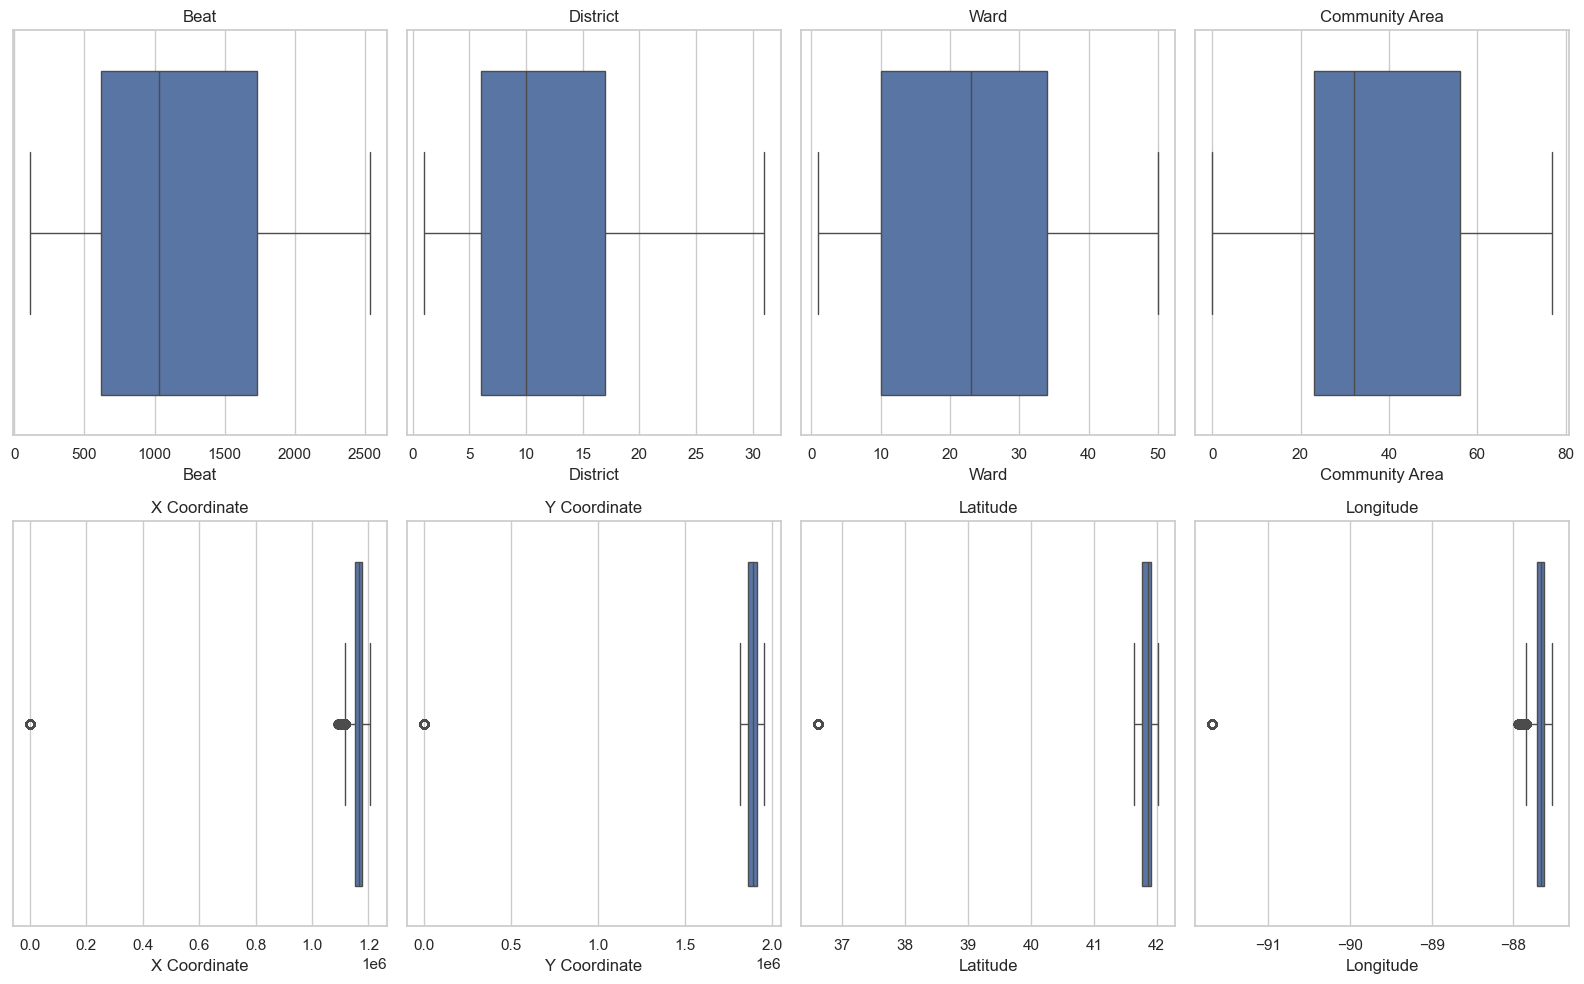

In [9]:
sns.set(style="whitegrid")
columns_to_plot = ['Beat', 'District', 'Ward', 'Community Area',
                   'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude']

# Create boxplots
plt.figure(figsize=(16, 10))
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

In [10]:
df = df.dropna()
df = df[(df['X Coordinate'] != 0) & (df['Y Coordinate'] != 0)]

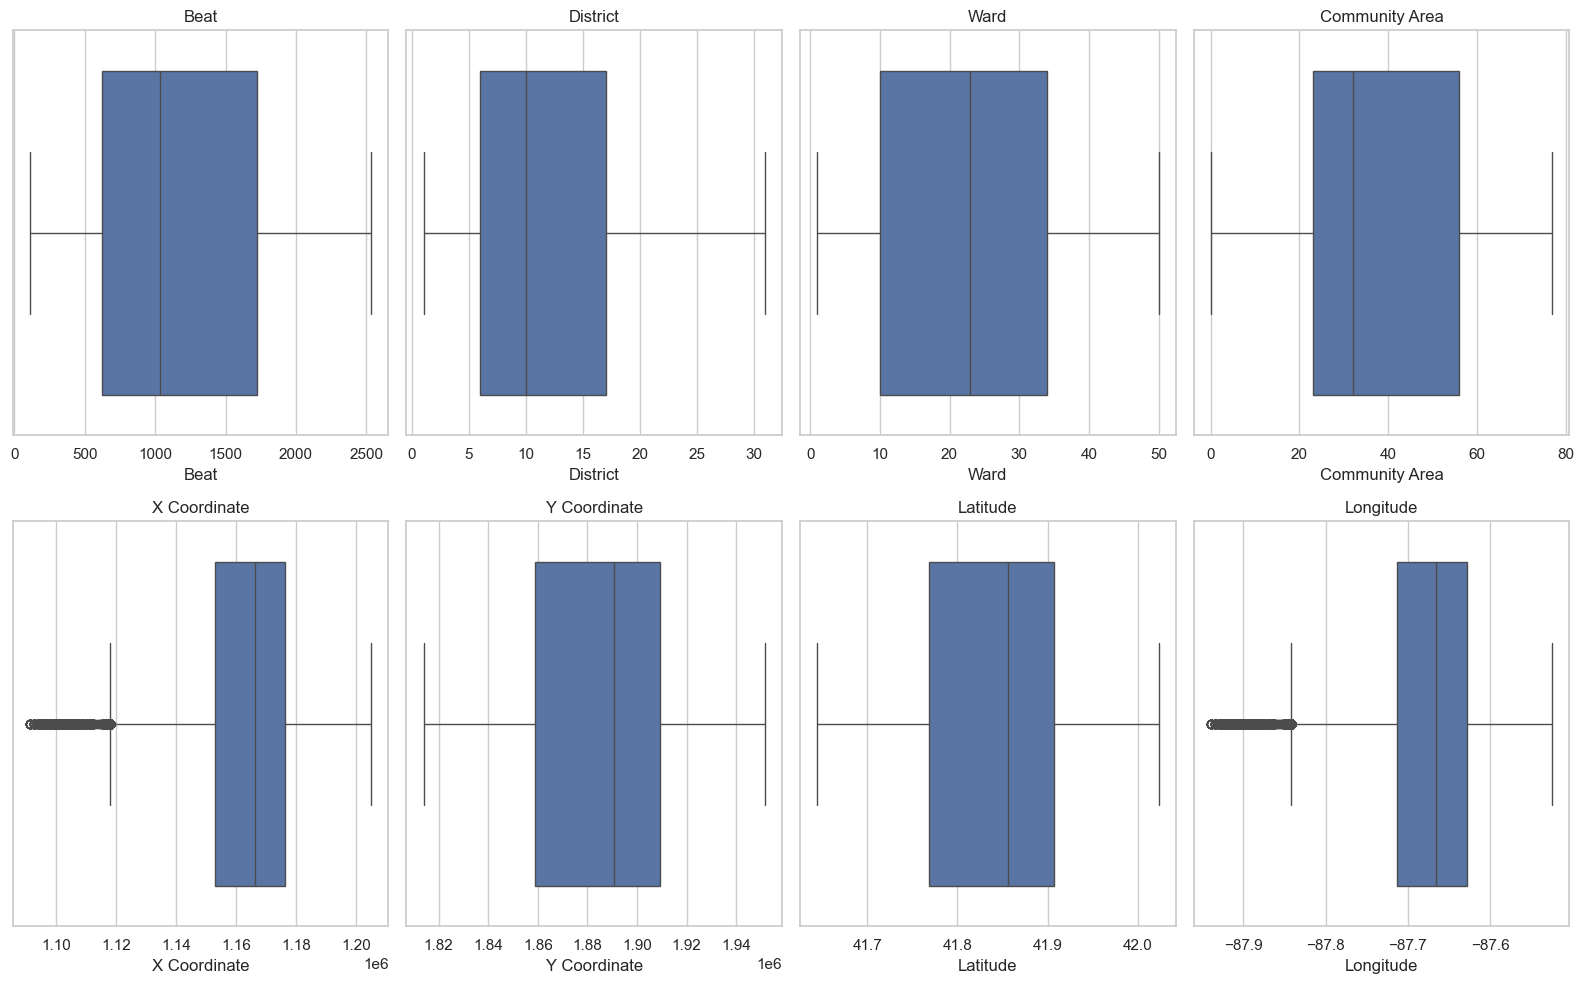

In [11]:
sns.set(style="whitegrid")
columns_to_plot = ['Beat', 'District', 'Ward', 'Community Area',
                   'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude']

# Create boxplots
plt.figure(figsize=(16, 10))
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588259 entries, 3 to 8296189
Data columns (total 22 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    object        
 1   Case Number           object        
 2   Date                  datetime64[ns]
 3   Block                 object        
 4   IUCR                  object        
 5   Primary Type          object        
 6   Description           object        
 7   Location Description  object        
 8   Arrest                bool          
 9   Domestic              bool          
 10  Beat                  int64         
 11  District              float64       
 12  Ward                  float64       
 13  Community Area        float64       
 14  FBI Code              object        
 15  X Coordinate          float64       
 16  Y Coordinate          float64       
 17  Year                  int64         
 18  Updated On            object        
 19  Latit

In [13]:
print(round(7588259 / 8296190 * 100,2), "% of the data has been retained.")

91.47 % of the data has been retained.


Dropping the rows will usually result in clean datasets and produce well-behaved data. But often, it removes a lot of information that reduces result accuracy.
However, in our case, since 91.47% of the data is retained and since there is practically no other way to work around the type of missing values we have, we shall go ahead with this slightly diminished dataset

In [14]:
print(df.nunique())

ID                      7588259
Case Number             7587682
Date                    3183561
Block                     39420
IUCR                        420
Primary Type                 35
Description                 568
Location Description        218
Arrest                        2
Domestic                      2
Beat                        304
District                     24
Ward                         50
Community Area               78
FBI Code                     27
X Coordinate              75798
Y Coordinate             126140
Year                         25
Updated On                 5501
Latitude                 687042
Longitude                686653
Location                 687775
dtype: int64


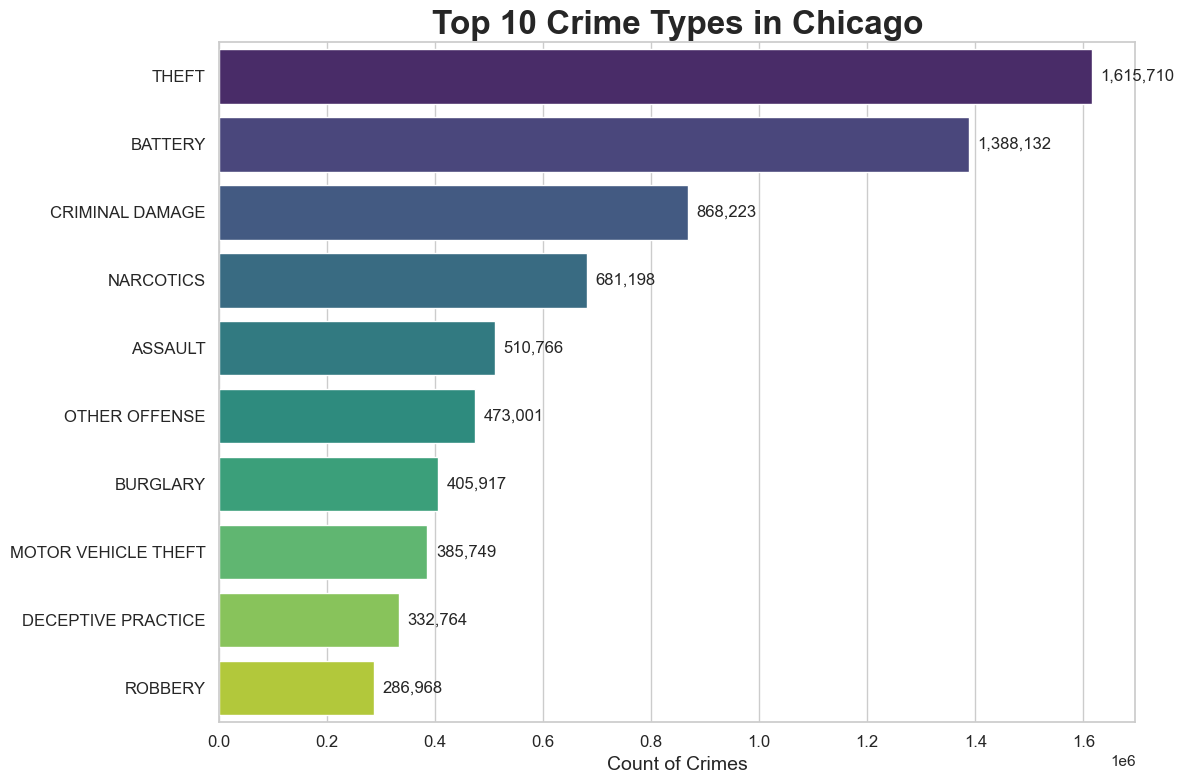

In [15]:
temp = df.groupby('Primary Type', as_index=False).agg({"ID": "count"})
temp = temp.sort_values(by='ID', ascending=False).head(10)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

barplot = sns.barplot(
    x='ID',
    y='Primary Type',
    data=temp,
    hue='Primary Type',
    palette='viridis',
    dodge=False,
    legend=False
)

for index, value in enumerate(temp['ID']):
    barplot.text(value + max(temp['ID']) * 0.01, index, f'{value:,}', va='center', fontsize=12)

# Titles and labels
plt.title("Top 10 Crime Types in Chicago", fontsize=24, fontweight='bold')
plt.xlabel("Count of Crimes", fontsize=14)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


<Axes: title={'center': 'Crimes Over Time'}, xlabel='Month'>

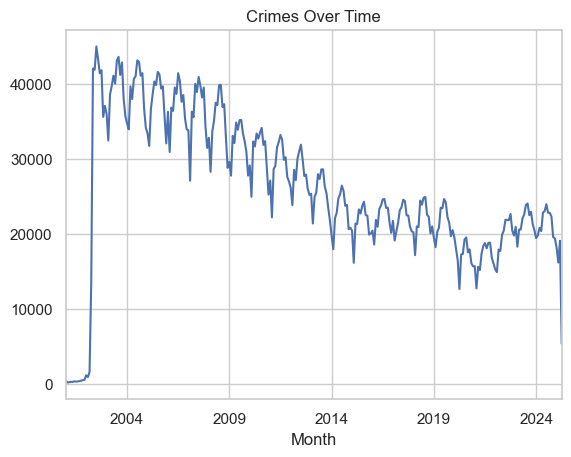

In [16]:
df_temp = df.copy()
df_temp['Month'] = df['Date'].dt.to_period('M')
df_temp.groupby('Month').size().plot(kind='line', title='Crimes Over Time')

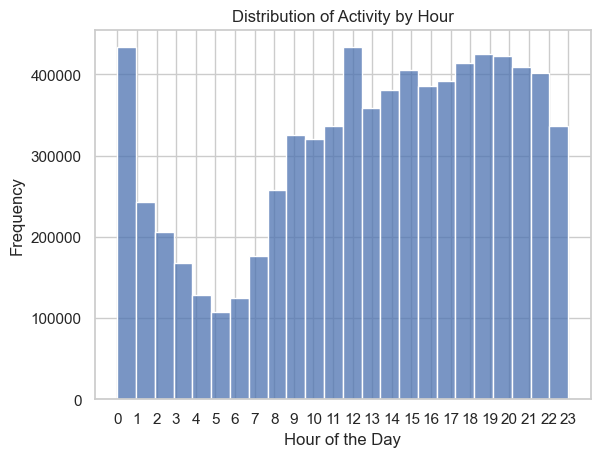

In [17]:
df_temp['Hour'] = df['Date'].dt.hour

sns.histplot(df_temp['Hour'], bins=24)


plt.xticks(ticks=range(24), labels=[str(i) for i in range(24)])

plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Distribution of Activity by Hour')
plt.show()

<Axes: xlabel='Hour', ylabel='DayOfWeek'>

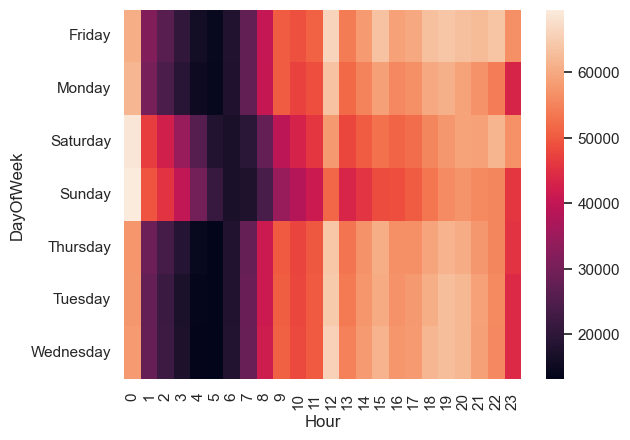

In [18]:
df_temp['DayOfWeek'] = df['Date'].dt.day_name()
pivot = df_temp.pivot_table(index='DayOfWeek', columns='Hour', values='ID', aggfunc='count')
sns.heatmap(pivot)

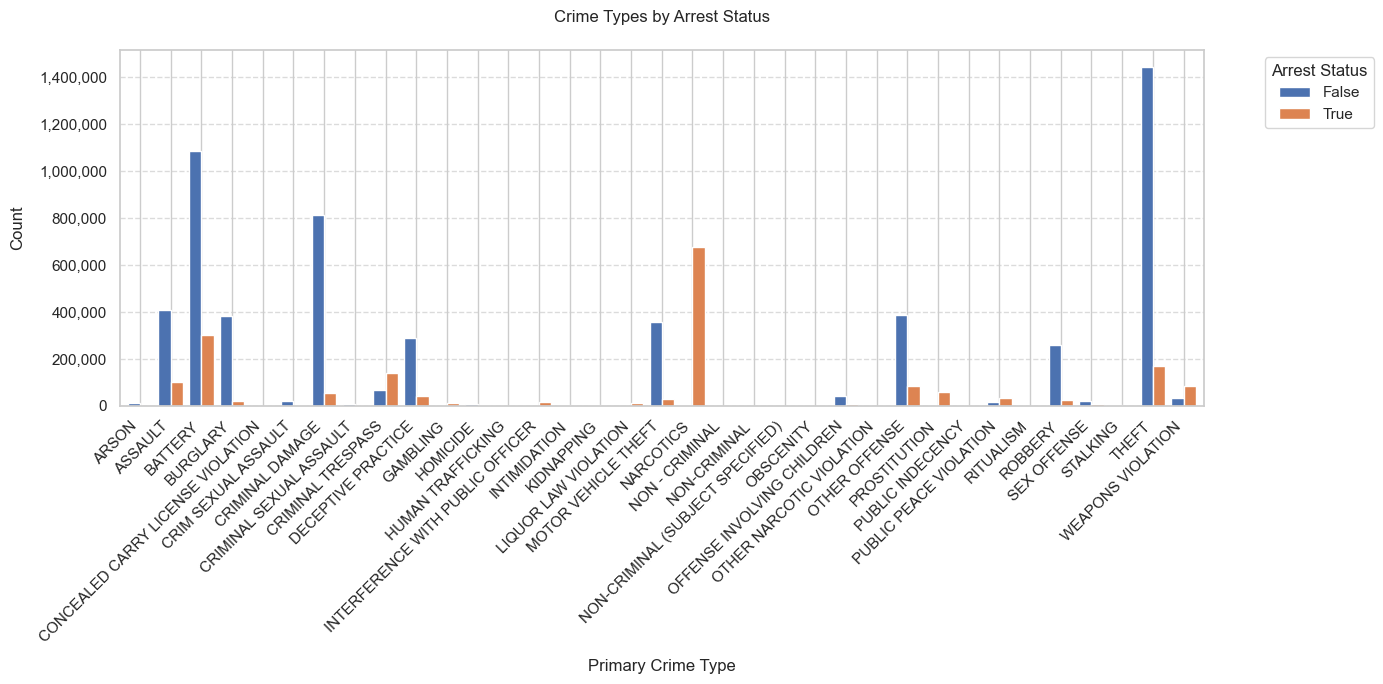

In [19]:
cross_tab = pd.crosstab(df['Primary Type'], df['Arrest'])
ax = cross_tab.plot(kind='bar', figsize=(14, 7), width=0.8)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # 1,000,000 format
plt.title('Crime Types by Arrest Status', pad=20)
plt.xlabel('Primary Crime Type', labelpad=10)
plt.ylabel('Count', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional grid
plt.legend(title='Arrest Status', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Spatial Data Analysis

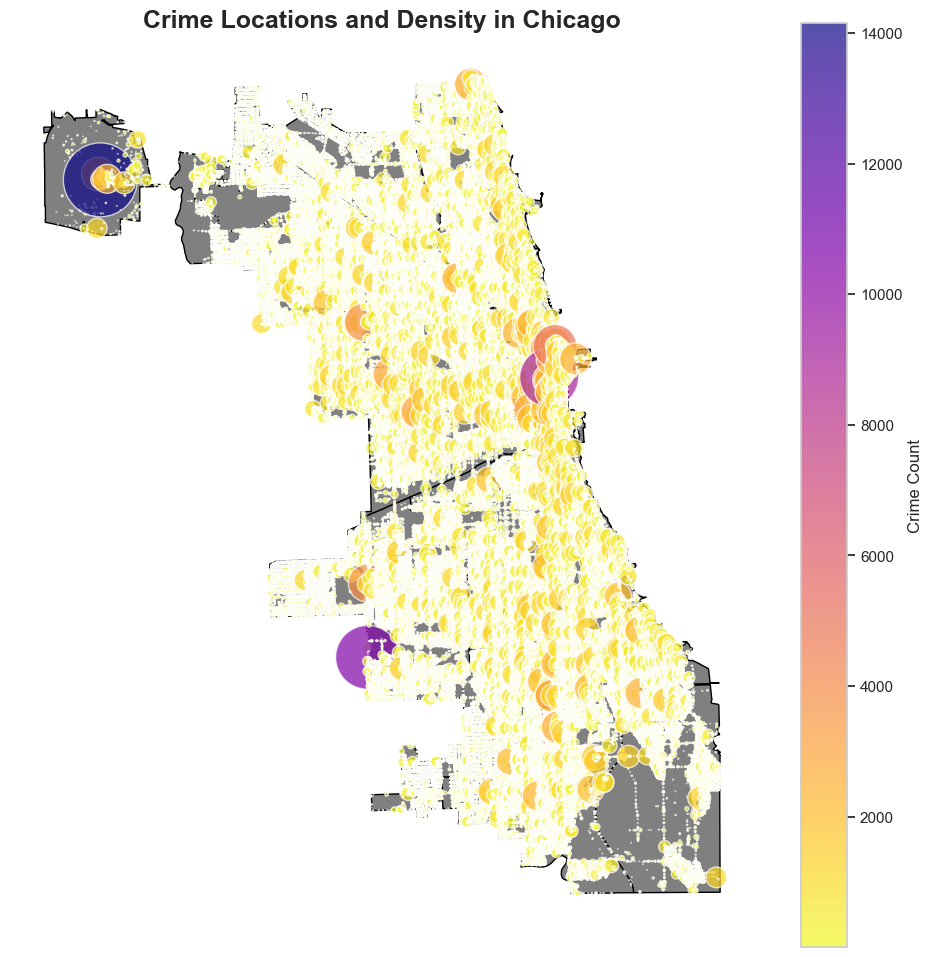

In [20]:
crime_counts = df.groupby(['X Coordinate', 'Y Coordinate']).size().reset_index(name='Crime_Count')
fig, ax = plt.subplots(figsize=(12, 12))
chicago_map.plot(ax=ax, color='gray', edgecolor='black')
scatter = ax.scatter(
    crime_counts['X Coordinate'], 
    crime_counts['Y Coordinate'], 
    c=crime_counts['Crime_Count'], 
    cmap='plasma_r',  
    s=crime_counts['Crime_Count'] * 0.2,
    alpha=0.7, 
    edgecolors='w', 
    label='Crime Locations'
)

plt.colorbar(scatter, ax=ax, label='Crime Count')

ax.set_title("Crime Locations and Density in Chicago", fontsize=18, weight='bold')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.axis('off') 

plt.show()


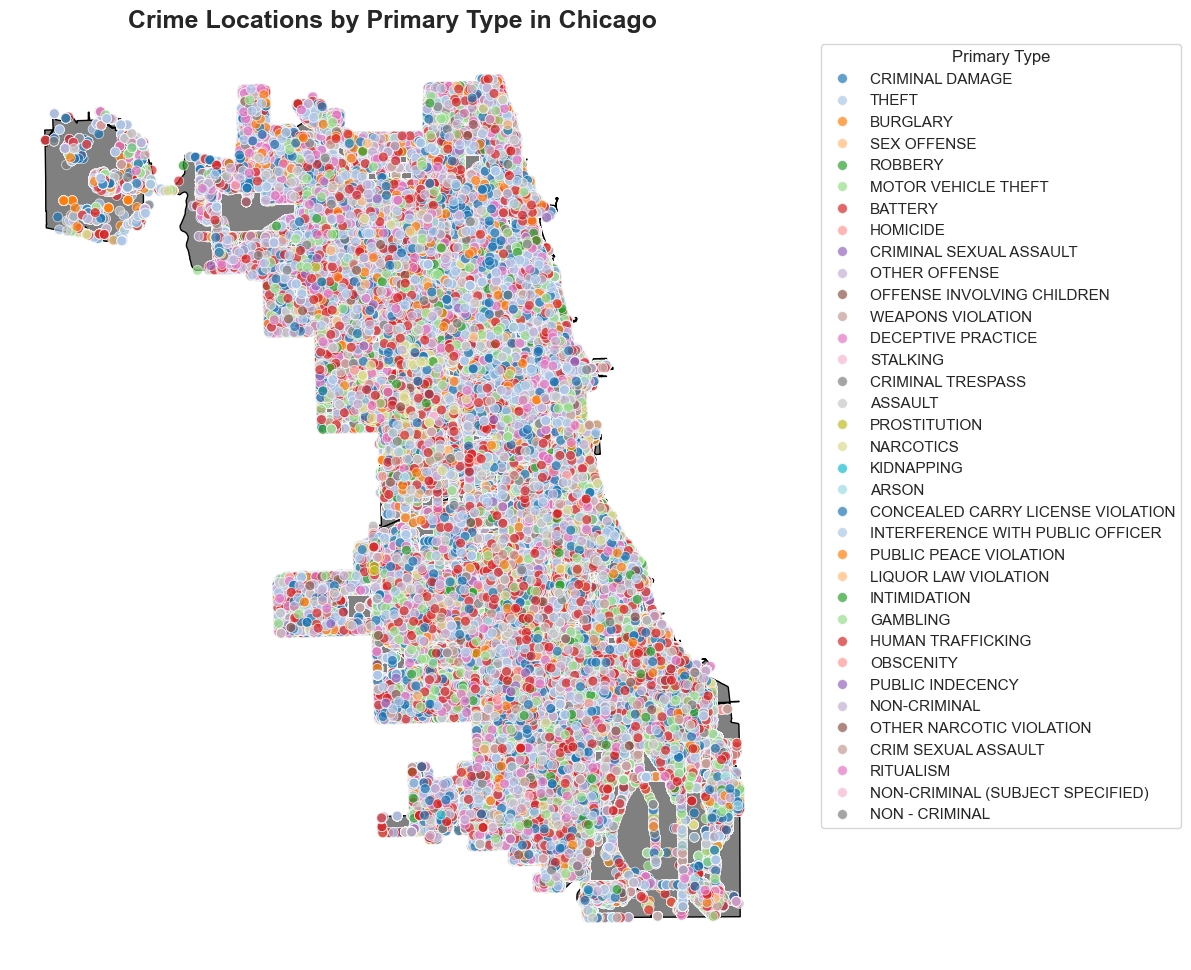

In [21]:

fig, ax = plt.subplots(figsize=(12, 12))
chicago_map.plot(ax=ax, color='gray', edgecolor='black')

sns.scatterplot(
    x='X Coordinate', 
    y='Y Coordinate', 
    hue='Primary Type',   
    data=df, 
    palette='tab20',
    s=50,  
    alpha=0.7, 
    edgecolor='w', 
    legend=True,
    ax=ax
)

ax.set_title("Crime Locations by Primary Type in Chicago", fontsize=18, weight='bold')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.axis('off')


plt.legend(title='Primary Type', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()


# Sampling

In [22]:
def sample_crime_data_df(df, sample_size=0.2, random_state=42):
    print("Starting sampling ..")
    df['_strata_hash'] = (
        df['Date'].dt.day_name().apply(hash)^ 
        df['Primary Type'].apply(hash) ^ 
        df['Description'].apply(hash) ^ 
        df['Arrest'].apply(hash) ^ 
        df['Ward'].apply(hash) ^ 
        df['Community Area'].apply(hash))
    
    samples = []
    for _, group in df.groupby('_strata_hash', group_keys=False):
        if len(group) == 1:
            samples.append(group)
        else:
            samples.append(group.sample(frac=sample_size, random_state=random_state))
    
    result = pd.concat(samples)
    del df['_strata_hash']  
    if '_strata_hash' in result:
        del result['_strata_hash']
    return result
    
df_sample = sample_crime_data_df(df, sample_size=0.5)

# Verify the sample maintains distributions
cols_to_check = ['Date', 'Primary Type', 'Description', 'Arrest', 'Ward', 'Community Area']

print("\n=== Distribution Comparison for Stratification Columns ===")
for col in cols_to_check:
    if col == 'Date':
        print(f"\n--- Column: {col} (Weekday) ---")
        orig = df['Date'].dt.day_name().value_counts(normalize=True)
        sample = df_sample['Date'].dt.day_name().value_counts(normalize=True)
    else:
        print(f"\n--- Column: {col} ---")
        orig = df[col].value_counts(normalize=True)
        sample = df_sample[col].value_counts(normalize=True)
    
    comparison = pd.concat([orig.rename('original'), sample.rename('sample')], axis=1).fillna(0)
    print(comparison.head(10))


Starting sampling ..

=== Distribution Comparison for Stratification Columns ===

--- Column: Date (Weekday) ---
           original  sample
Date                       
Friday         0.15    0.15
Saturday       0.14    0.14
Wednesday      0.14    0.14
Tuesday        0.14    0.14
Thursday       0.14    0.14
Monday         0.14    0.14
Sunday         0.14    0.14

--- Column: Primary Type ---
                     original  sample
Primary Type                         
THEFT                    0.21    0.21
BATTERY                  0.18    0.18
CRIMINAL DAMAGE          0.11    0.11
NARCOTICS                0.09    0.09
ASSAULT                  0.07    0.07
OTHER OFFENSE            0.06    0.06
BURGLARY                 0.05    0.05
MOTOR VEHICLE THEFT      0.05    0.05
DECEPTIVE PRACTICE       0.04    0.04
ROBBERY                  0.04    0.04

--- Column: Description ---
                              original  sample
Description                                   
SIMPLE                    

**Sampling Rationale and Methodology**  

Sampling was employed to overcome computational constraints while preserving the dataset's key characteristics, enabling efficient clustering and predictive modeling on limited hardware. The stratified temporal sampling method was chosen to maintain representativeness across three critical dimensions: **time** (by year-month), **crime type distribution** (Primary Type), and **geographic distribution** (Community Area). By combining these factors into stratification keys, the sampling ensures that seasonal crime patterns, crime category frequencies, and spatial distributions in the sample mirror the full dataset. This approach prevents bias that might arise from simple random sampling, such as overlooking rare but important crime types or distorting temporal trends. The method efficiently reduces data volume while retaining statistical integrity, allowing for meaningful analysis without sacrificing hardware performance. Additionally, handling NaN values and optimizing data types further enhance memory efficiency, making the sampled dataset both manageable and analytically robust for machine learning tasks.

# Clustering

In [23]:

df_clustering = df_sample.copy()

# Feature engineering
df_clustering['datetime'] = pd.to_datetime(df_clustering['Date'])
df_clustering['hour'] = df_clustering['datetime'].dt.hour
df_clustering['day_of_week'] = df_clustering['datetime'].dt.dayofweek
df_clustering['is_weekend'] = (df_clustering['day_of_week'] >= 5).astype(int)
# Encode categorical variables 
le = LabelEncoder()
df_clustering['PrimaryTypeEncoded'] = le.fit_transform(df_clustering['Primary Type'])
df_clustering['DescriptionEncoded'] = le.fit_transform(df_clustering['Description'])

# 2. Feature selection and scaling
features = ['Community Area', 'hour', 'day_of_week', 'PrimaryTypeEncoded', 'is_weekend',
            'DescriptionEncoded']
available_features = [f for f in features if f in df_clustering.columns]

scaler = StandardScaler()
X = df_clustering[available_features]
X_scaled = scaler.fit_transform(X)



## K-MEANS

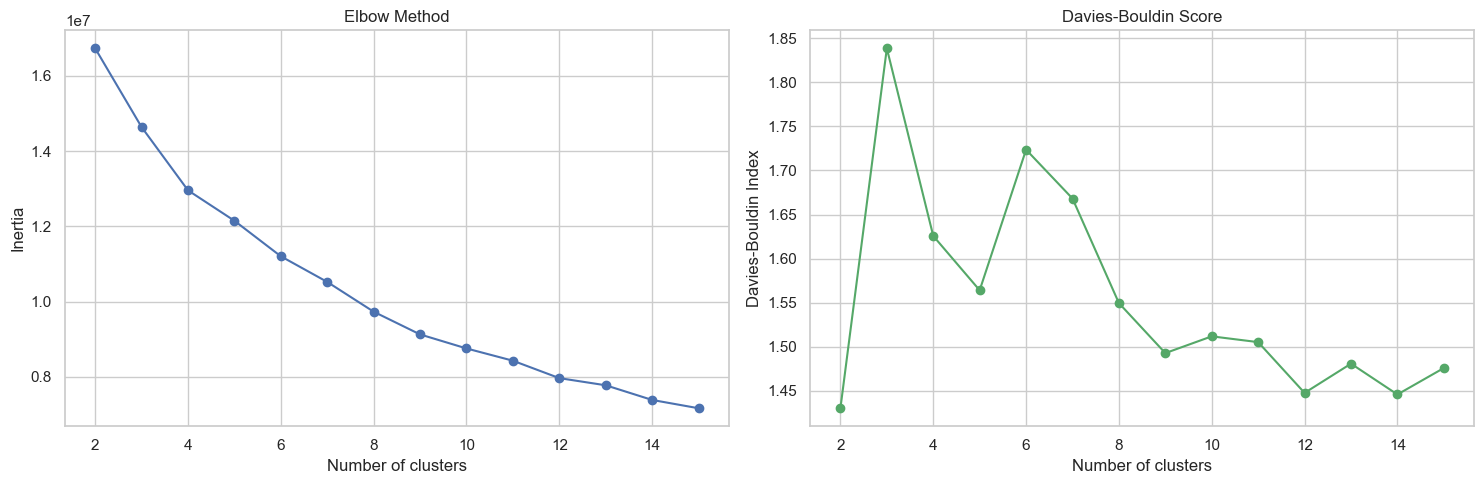

In [24]:
# Find optimal k
inertias = []
db_scores = []
k_values = range(2, 16)

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

# Plot evaluation metrics
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_values, db_scores, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Score')
plt.tight_layout()
plt.show()

The analysis utilized two key methods to determine the optimal number of clusters for the dataset: the Elbow Method and the Davies-Bouldin Score. The **Elbow Method** plots the sum of squared distances to the nearest cluster centroid (inertia) against the number of clusters. The "elbow" of the curve, where the rate of decrease in inertia significantly slows, suggests the optimal number of clusters, as adding more clusters beyond this point provides diminishing returns in terms of reducing within-cluster variance. Simultaneously, the **Davies-Bouldin Score** evaluates the quality of clustering by considering the ratio of within-cluster scatter to between-cluster separation; a lower score indicates better clustering, with clusters being more compact and further apart. By observing the Elbow Method plot, a clear "elbow" was identified around 5-7 clusters, indicating a good balance between minimizing inertia and not creating an excessive number of clusters. This finding was further corroborated by the Davies-Bouldin Score plot, which showed its lowest value at 6 clusters, signifying the most optimal separation and compactness among the clusters. Consequently, based on the convergence of evidence from both methods, **6 clusters** was selected as the most appropriate and robust choice for this dataset.

/var/folders/yy/28_7jpn15pg4fw406w_5vd5r0000gp/T/ipykernel_1541/2818043151.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


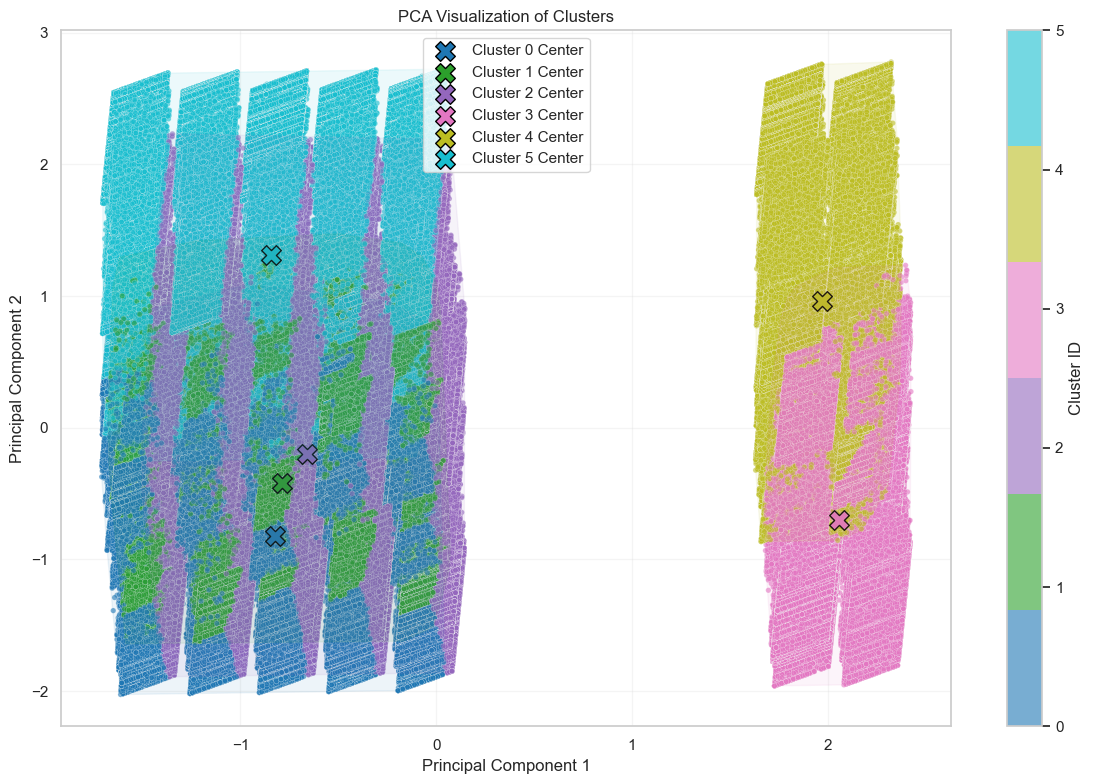

In [25]:
n_clusters = 6
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
df_clustering['cluster'] = kmeans_labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(12, 8))
cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
discrete_cmap = ListedColormap(cluster_colors)

scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels,
    cmap=discrete_cmap,
    alpha=0.6,
    s=15,
    edgecolors='w',
    linewidths=0.2
)

for i, center in enumerate(centers_pca):
    plt.scatter(center[0], center[1], marker='X', s=200,
                c=[cluster_colors[i]], edgecolor='black',
                linewidth=1, label=f'Cluster {i} Center')

for cluster in range(n_clusters):
    cluster_points = X_pca[kmeans_labels == cluster]
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        plt.fill(cluster_points[hull.vertices, 0],
                 cluster_points[hull.vertices, 1],
                 alpha=0.08,
                 color=cluster_colors[cluster])

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.2)
plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster ID')
plt.legend()
plt.tight_layout()
plt.show()




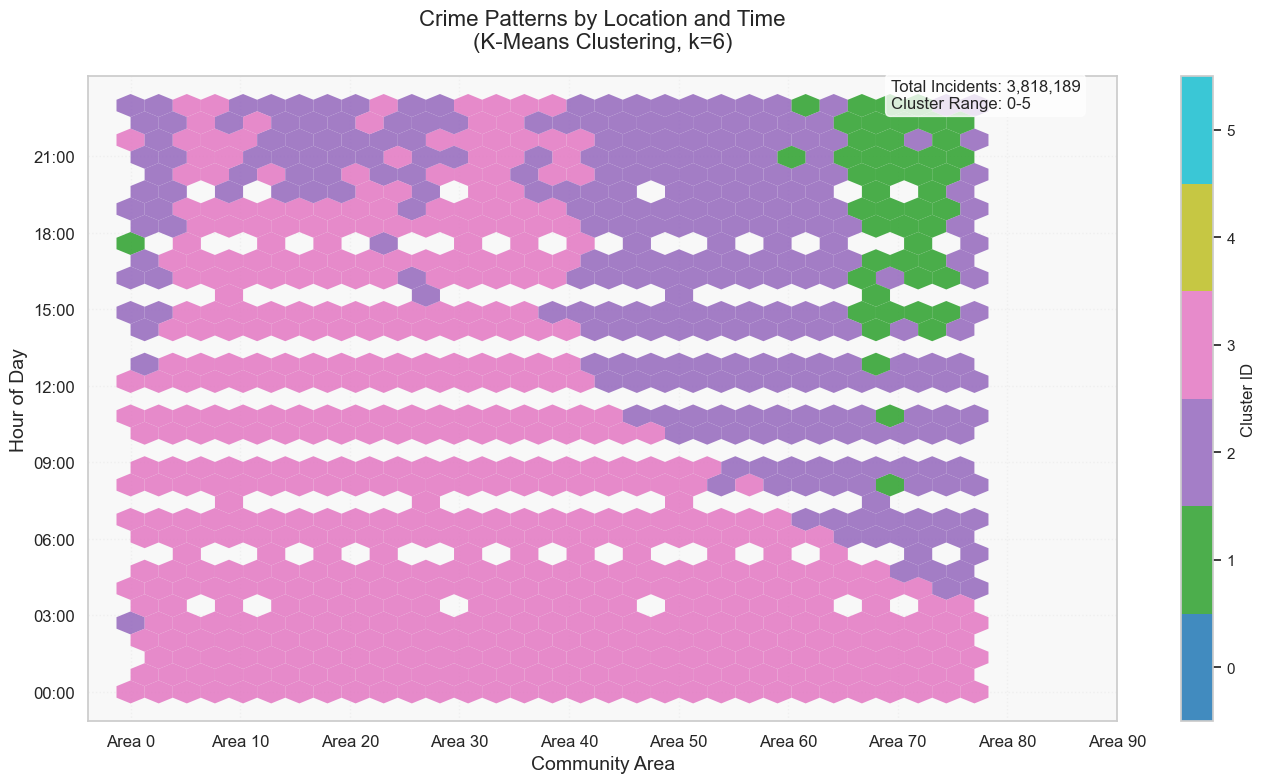

In [26]:

viz_df = pd.DataFrame({
    'CommunityArea': df_clustering['Community Area'],
    'Hour': df_clustering['hour'],
    'KMeans_Cluster': df_clustering['cluster'], 
    'PrimaryType': df_clustering['Primary Type'],
    'Description': df_clustering['Description']
})

plot_df = viz_df.dropna(subset=['CommunityArea', 'Hour', 'KMeans_Cluster']).copy()
n_clusters = plot_df['KMeans_Cluster'].nunique()


cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
discrete_cmap = ListedColormap(cluster_colors)


plt.figure(figsize=(14, 8))
hexbin = plt.hexbin(
    plot_df['CommunityArea'],
    plot_df['Hour'],
    C=plot_df['KMeans_Cluster'],
    gridsize=30,
    cmap=discrete_cmap,
    alpha=0.85,
    mincnt=1,
    edgecolors='none',
    vmin=-0.5,
    vmax=n_clusters - 0.5
)

cbar = plt.colorbar(hexbin, label='Cluster ID')
cbar.set_ticks(range(n_clusters))
cbar.set_ticklabels(range(n_clusters))

plt.title(f'Crime Patterns by Location and Time\n(K-Means Clustering, k={n_clusters})',
          fontsize=16, pad=20)
plt.xlabel('Community Area', fontsize=14)
plt.ylabel('Hour of Day', fontsize=14)

plt.xticks(np.arange(0, 100, 10), labels=[f'Area {x}' for x in range(0, 100, 10)], fontsize=12)
plt.yticks(np.arange(0, 24, 3), labels=[f'{h:02d}:00' for h in range(0, 24, 3)], fontsize=12)

plt.grid(True, alpha=0.2, linestyle=':')
plt.gca().set_facecolor('#f8f8f8')

plt.annotate(
    f'Total Incidents: {len(plot_df):,}\nCluster Range: 0-{n_clusters - 1}',
    xy=(0.78, 0.95), xycoords='axes fraction',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig(f'kmeans_{n_clusters}clusters_spatiotemporal.png', dpi=300, bbox_inches='tight',
            facecolor='#f8f8f8')
plt.show()



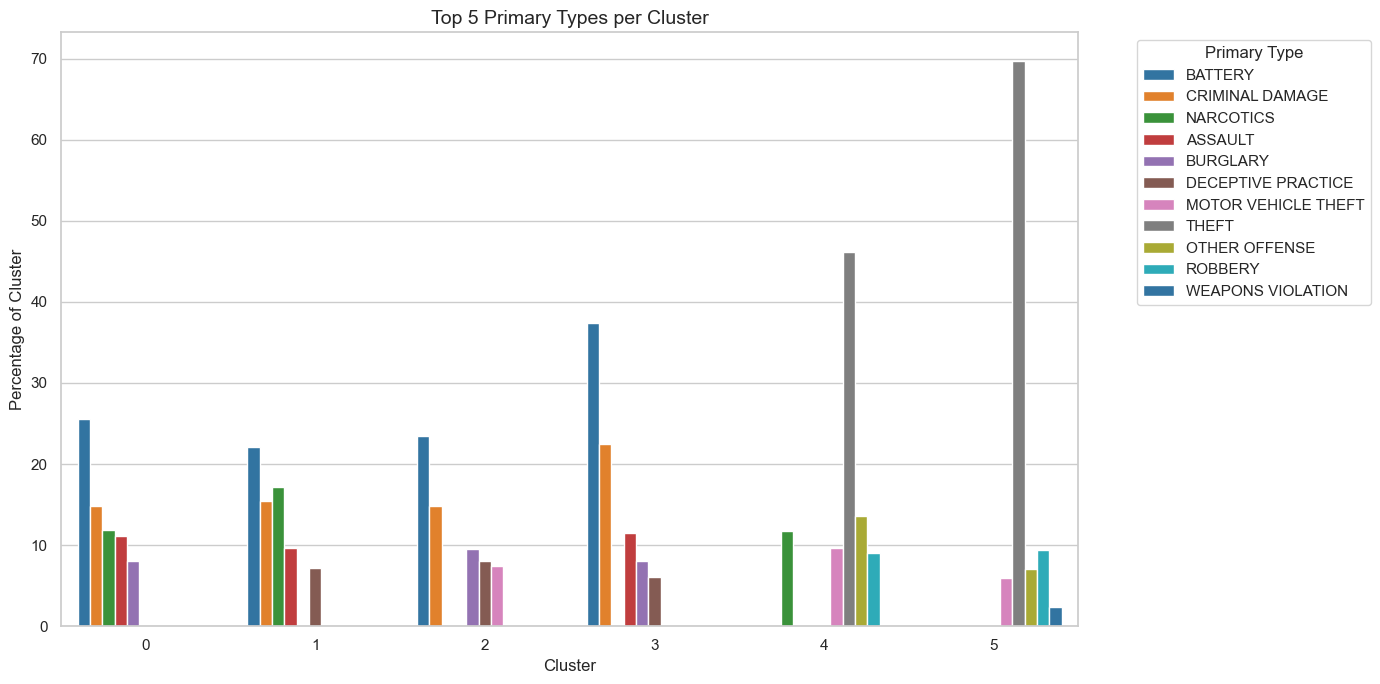

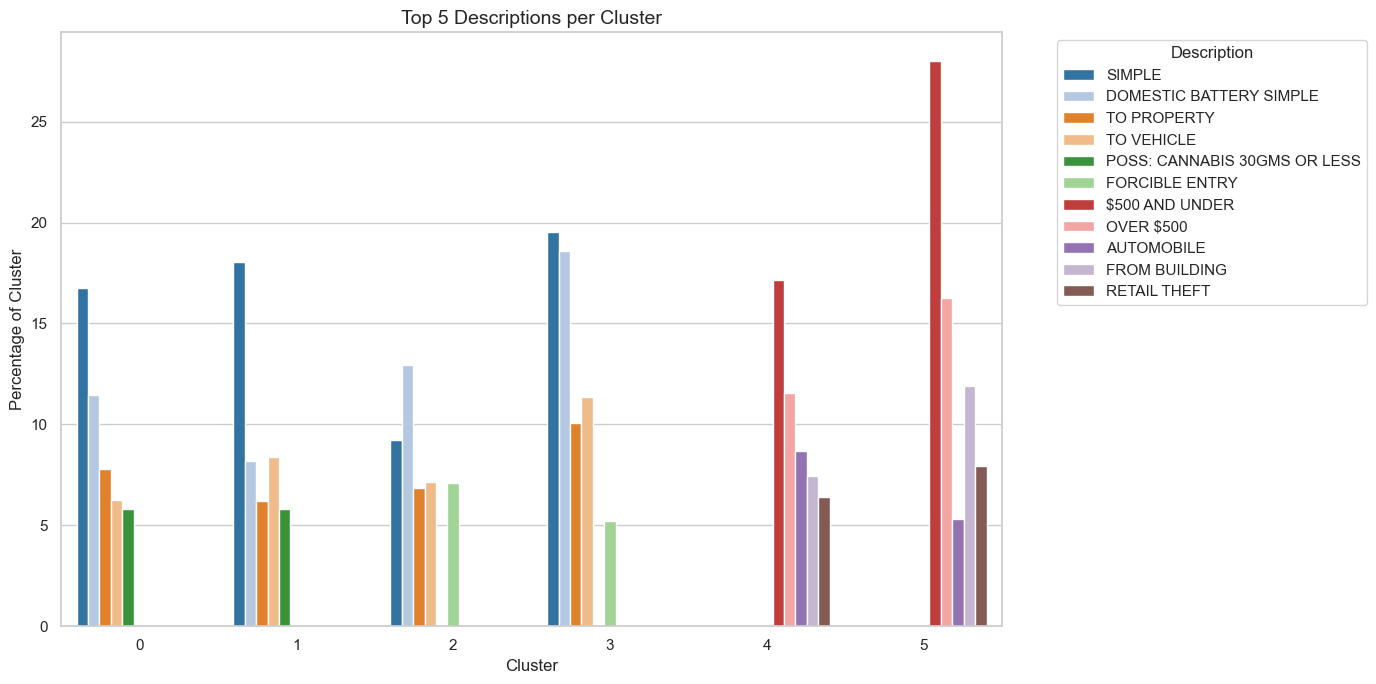


Cluster Incident Distribution:
KMeans_Cluster
0    708013
1    752128
2    528322
3    602676
4    468800
5    758250
Name: count, dtype: int64

Top 5 Primary Types per Cluster:
     KMeans_Cluster          PrimaryType   count  percentage
2                 0              BATTERY  181188       25.59
6                 0      CRIMINAL DAMAGE  104900       14.82
18                0            NARCOTICS   83608       11.81
1                 0              ASSAULT   79162       11.18
3                 0             BURGLARY   56621        8.00
36                1              BATTERY  166280       22.11
52                1            NARCOTICS  128964       17.15
40                1      CRIMINAL DAMAGE  115779       15.39
35                1              ASSAULT   72785        9.68
43                1   DECEPTIVE PRACTICE   53691        7.14
70                2              BATTERY  123930       23.46
74                2      CRIMINAL DAMAGE   78594       14.88
71                2         

In [27]:
cluster_sizes = plot_df['KMeans_Cluster'].value_counts().to_dict()

top5_primary_types = (
    plot_df.groupby(['KMeans_Cluster', 'PrimaryType'])
    .size()
    .reset_index(name='count')
    .sort_values(['KMeans_Cluster', 'count'], ascending=[True, False])
    .groupby('KMeans_Cluster')
    .head(5))
top5_primary_types['percentage'] = top5_primary_types.apply(
    lambda row: 100 * row['count'] / cluster_sizes[row['KMeans_Cluster']], axis=1)

top5_descriptions = (
    plot_df.groupby(['KMeans_Cluster', 'Description'])
    .size()
    .reset_index(name='count')
    .sort_values(['KMeans_Cluster', 'count'], ascending=[True, False])
    .groupby('KMeans_Cluster')
    .head(5))
top5_descriptions['percentage'] = top5_descriptions.apply(
    lambda row: 100 * row['count'] / cluster_sizes[row['KMeans_Cluster']], axis=1)

plt.figure(figsize=(14, 7))
sns.barplot(
    data=top5_primary_types,x='KMeans_Cluster',y='percentage',hue='PrimaryType',
    dodge=True,
    palette='tab10')
plt.title('Top 5 Primary Types per Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Percentage of Cluster')
plt.legend(title='Primary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'kmeans_{n_clusters}_top5_primary_types_barplot.png', dpi=300)
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(
    data=top5_descriptions,x='KMeans_Cluster',y='percentage',hue='Description',dodge=True,
    palette='tab20')
plt.title('Top 5 Descriptions per Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Percentage of Cluster')
plt.legend(title='Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'kmeans_{n_clusters}_top5_descriptions_barplot.png', dpi=300)
plt.show()

print("\nCluster Incident Distribution:")
print(plot_df['KMeans_Cluster'].value_counts().sort_index())
print("\nTop 5 Primary Types per Cluster:")
print(top5_primary_types[['KMeans_Cluster', 'PrimaryType', 'count', 'percentage']])
print("\nTop 5 Descriptions per Cluster:")
print(top5_descriptions[['KMeans_Cluster', 'Description', 'count', 'percentage']])



The KMeans clustering analysis revealed six distinct crime pattern clusters in the dataset. Cluster 0 is predominantly characterized by property crimes, especially low-value thefts such as THEFT 500 AND UNDER, which accounts for over half the incidents. Cluster 1 and Cluster 2 are both dominated by violent offenses, with high proportions of BATTERY,ASSAULT, and CRIMINAL DAMAGE.
Cluster 1 includes a significant number of domestic-related incidents like Domestic Battery Simple, while Cluster 2 exhibits even higher levels of battery and burglary. Cluster 3 reflects a concentration of retail and property theft, along with drug-related offenses such as NARCOTICS, suggesting a link to commercial areas with petty crime and substance abuse activity. Cluster 4, the largest cluster, represents a mix of violent and deceptive offenses, including BATTERY,CRIMINAL DAMAGE, and DECEPTIVE PRACTICE, indicative of diverse urban neighborhoods. Lastly, Cluster 5 focuses heavily on high-value thefts and drug violations, with notable contributions from offenses like THEFT OVER 500,RETAIL THEFT,and cannabis possession, pointing toward organized retail crime and narcotics-related activity. Overall, KMeans effectively separated the dataset into meaningful clusters, distinguishing between property-heavy, violent, and mixed-crime zones based on both primary type and descriptive context.


## DB SCAN (Not Working, kernel times out not needed much as K-Means showed clusters)

In [28]:
# # 4. DBSCAN Clustering
# # Optimized DBSCAN parameters
# dbscan_params = {'eps': 0.5, 'min_samples': 50}
# dbscan = DBSCAN(**dbscan_params)
# dbscan_labels = dbscan.fit_predict(X_scaled)
# df_clustering['DBSCAN_Cluster'] = dbscan_labels
# # Print DBSCAN results
# n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
# print(f"\nDBSCAN found {n_clusters} clusters with parameters: {dbscan_params}")
# print(f"Noise points: {sum(dbscan_labels == -1)}")

In [29]:
# # 1. Compute PCA components (if not already done)
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# # 2. Create the enhanced DBSCAN plot
# plt.figure(figsize=(14, 8))

# # Cluster parameters
# unique_clusters = np.unique(dbscan_labels)
# n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

# # Create discrete colormap (skip the noise color)
# cluster_colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))  # Using tab20 for more distinct colors
# discrete_cmap = ListedColormap(cluster_colors)

# # Plot non-noise points with discrete coloring
# non_noise_mask = dbscan_labels != -1
# scatter = plt.scatter(X_pca[non_noise_mask, 0], X_pca[non_noise_mask, 1],
#                      c=dbscan_labels[non_noise_mask],
#                      cmap=discrete_cmap,
#                      alpha=0.7,
#                      s=15,
#                      edgecolors='w',
#                      linewidths=0.3,
#                      vmin=-0.5,
#                      vmax=n_clusters-0.5)

# # Plot noise points separately
# noise_mask = dbscan_labels == -1
# if sum(noise_mask) > 0:
#     noise = plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1],
#                        c='gray',
#                        alpha=0.15,
#                        s=8,
#                        label='Noise')

# # Add convex hulls for each cluster
# for i, cluster in enumerate(np.unique(dbscan_labels)):
#     if cluster == -1:
#         continue
#     cluster_points = X_pca[dbscan_labels == cluster]
#     if len(cluster_points) > 2:
#         hull = ConvexHull(cluster_points)
#         plt.fill(cluster_points[hull.vertices, 0],
#                  cluster_points[hull.vertices, 1],
#                  alpha=0.1,
#                  color=cluster_colors[i])

# # Formatting
# plt.title(f'DBSCAN Clusters in PCA Space\nParameters: eps={dbscan_params["eps"]}, min_samples={dbscan_params["min_samples"]}\nClusters: {n_clusters} | Noise: {sum(noise_mask)} points',
#           fontsize=14, pad=20)
# plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)',
#            fontsize=12)
# plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)',
#            fontsize=12)

# # Style enhancements
# plt.grid(True, alpha=0.15, linestyle=':')
# plt.gca().set_facecolor('#f8f8f8')

# # Create custom colorbar (excluding noise)
# cbar = plt.colorbar(scatter, ticks=range(n_clusters))
# cbar.set_label('Cluster ID', rotation=270, labelpad=20)

# # Add legend if noise exists
# if sum(noise_mask) > 0:
#     plt.legend(loc='upper right')

# plt.tight_layout()
# plt.show()

# # Save high-quality version
# plt.savefig(f'dbscan_clusters_pca_discrete.png', 
#             dpi=300, 
#             bbox_inches='tight',
#             facecolor='#f8f8f8')

# # Cluster diagnostics
# print(f"\nDBSCAN Cluster Metrics:")
# print(f"Number of clusters: {n_clusters}")
# print(f"Noise points: {sum(noise_mask)} ({sum(noise_mask)/len(dbscan_labels):.1%} of data)")

# # if n_clusters > 1:
# #     valid_points = X_pca[non_noise_mask]
# #     valid_labels = dbscan_labels[non_noise_mask]
# #     print(f"\nDavies-Bouldin Index: {davies_bouldin_score(valid_points, valid_labels):.3f}")
# #     print(f"Silhouette Score: {silhouette_score(valid_points, valid_labels):.3f}")

# print("\nCluster Size Distribution:")
# cluster_counts = pd.Series(dbscan_labels).value_counts()
# # Sort clusters descending (excluding noise)
# print(cluster_counts[cluster_counts.index != -1].sort_values(ascending=False))
# if -1 in cluster_counts.index:
#     print(f"\nNoise points: {cluster_counts[-1]}")

In [30]:
# from matplotlib.colors import ListedColormap

# # 1. Create visualization dataframe for DBSCAN
# dbscan_viz_df = pd.DataFrame({
#     'CommunityArea': df_clustering['Community Area'],
#     'Hour': df_clustering['hour'],
#     'DBSCAN_Cluster': df_clustering['DBSCAN_Cluster'],  # Using DBSCAN labels
#     'PrimaryType': df_clustering['Primary Type'],
#     'Description': df_clustering['Description']
# })

# # 2. Filter data and handle noise
# plot_df = dbscan_viz_df.dropna(subset=['CommunityArea', 'Hour', 'DBSCAN_Cluster']).copy()
# valid_clusters = plot_df[plot_df['DBSCAN_Cluster'] != -1]['DBSCAN_Cluster'].unique()
# n_clusters = len(valid_clusters)

# # 3. Create discrete colormap (excluding noise)
# cluster_colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))  # Using tab20 for more distinct colors
# discrete_cmap = ListedColormap(cluster_colors)

# # 4. Create the hexbin plot
# plt.figure(figsize=(16, 8))  # Slightly wider for legend

# # First plot noise points if they exist
# noise_mask = plot_df['DBSCAN_Cluster'] == -1
# # if noise_mask.any():
# plt.hexbin(plot_df.loc[noise_mask, 'CommunityArea'],
#                plot_df.loc[noise_mask, 'Hour'],
#                gridsize=30,
#                cmap='Greys',
#                alpha=0.2,
#                mincnt=1,
#                edgecolors='none')

# # Plot clustered points
# hexbin = plt.hexbin(
#     plot_df.loc[~noise_mask, 'CommunityArea'],
#     plot_df.loc[~noise_mask, 'Hour'],
#     C=plot_df.loc[~noise_mask, 'DBSCAN_Cluster'],
#     gridsize=30,
#     cmap=discrete_cmap,
#     alpha=0.85,
#     mincnt=1,
#     edgecolors='none',
#     vmin=-0.5,
#     vmax=n_clusters-0.5
# )

# # Create colorbar (excluding noise)
# cbar = plt.colorbar(hexbin, label='Cluster ID')
# cbar.set_ticks(range(n_clusters))
# cbar.set_ticklabels([f'Cluster {i}' for i in range(n_clusters)])

# # Enhanced formatting
# plt.title(f'Crime Hotspots by Location and Time\n(DBSCAN Clustering: {n_clusters} clusters)', 
#           fontsize=16, pad=20)
# plt.xlabel('Community Area', fontsize=14)
# plt.ylabel('Hour of Day', fontsize=14)

# # Improved axis ticks
# plt.xticks(np.arange(0, 100, 10), 
#            labels=[f'Area {x}' for x in range(0, 100, 10)],
#            fontsize=12, rotation=45)
# plt.yticks(np.arange(0, 24, 3), 
#            labels=[f'{h:02d}:00' for h in range(0, 24, 3)],
#            fontsize=12)

# # Style enhancements
# plt.grid(True, alpha=0.15, linestyle=':')
# plt.gca().set_facecolor('#f9f9f9')

# # Information box
# noise_count = noise_mask.sum()
# cluster_count = len(plot_df) - noise_count
# plt.annotate(f'Clustered Incidents: {cluster_count:,}\nNoise Points: {noise_count:,}',
#              xy=(0.78, 0.95), xycoords='axes fraction',
#              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# plt.tight_layout()
# plt.show()

# # Save with parameters in filename
# plt.savefig(f'dbscan_eps{dbscan_params["eps"]}_min{dbscan_params["min_samples"]}_clusters.png', 
#             dpi=300, 
#             bbox_inches='tight',
#             facecolor='#f9f9f9')

# # Cluster diagnostics
# print("\nDBSCAN Cluster Analysis:")
# print(f"Parameters: eps={dbscan_params['eps']}, min_samples={dbscan_params['min_samples']}")
# print(f"Number of clusters: {n_clusters}")
# print(f"Noise points: {noise_count} ({noise_count/len(plot_df):.1%} of data)")

# if n_clusters > 0:
#     print("\nCluster Size Distribution:")
#     print(plot_df[~noise_mask]['DBSCAN_Cluster'].value_counts().sort_index())
    
#     # Print top crime per cluster
#     print("\nDominant Crime by Cluster:")
#     for cluster in sorted(valid_clusters):
#         cluster_data = plot_df[plot_df['DBSCAN_Cluster'] == cluster]
#         top_crime = cluster_data['PrimaryType'].mode()[0]
#         print(f"Cluster {cluster}: {top_crime} ({len(cluster_data)} incidents)")

# if noise_count > 0:
#     print("\nTop Crimes in Noise Points:")
#     print(plot_df[noise_mask]['PrimaryType'].value_counts().head(5))

In [31]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import DBSCAN
# from matplotlib.colors import ListedColormap
# from scipy.spatial import ConvexHull

# # ---------------------------------------
# # Step 1: DBSCAN Clustering
# # ---------------------------------------
# dbscan = DBSCAN(eps=1.2, min_samples=5)
# dbscan_labels = dbscan.fit_predict(X_scaled)
# df_clustering['dbscan_cluster'] = dbscan_labels

# # ---------------------------------------
# # Step 2: PCA Transformation (reuse or re-run)
# # ---------------------------------------
# # X_pca already computed in your previous code using:
# # pca = PCA(n_components=2)
# # X_pca = pca.fit_transform(X_scaled)

# # ---------------------------------------
# # Step 3: Plot DBSCAN Clusters in PCA Space
# # ---------------------------------------
# plt.figure(figsize=(12, 8))

# # Unique labels including noise (-1)
# unique_labels = np.unique(dbscan_labels)
# n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

# # Assign a color index to each label
# label_to_color_idx = {label: idx for idx, label in enumerate(unique_labels)}
# colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
# discrete_cmap = ListedColormap(colors)

# # Plot all points with their cluster color
# scatter = plt.scatter(
#     X_pca[:, 0],
#     X_pca[:, 1],
#     c=[label_to_color_idx[label] for label in dbscan_labels],
#     cmap=discrete_cmap,
#     alpha=0.6,
#     s=15,
#     edgecolors='w',
#     linewidths=0.2
# )

# # Convex hulls for valid clusters (skip noise and large sets)
# for cluster_id in unique_labels:
#     if cluster_id == -1:
#         continue  # Skip noise
#     cluster_points = X_pca[dbscan_labels == cluster_id]
#     if 3 <= len(cluster_points) <= 1000:
#         try:
#             hull = ConvexHull(cluster_points)
#             plt.fill(
#                 cluster_points[hull.vertices, 0],
#                 cluster_points[hull.vertices, 1],
#                 alpha=0.08,
#                 color=colors[label_to_color_idx[cluster_id]]
#             )
#         except Exception as e:
#             print(f"Skipping hull for cluster {cluster_id}: {e}")

# # Plot title and axes
# plt.title(f'PCA Visualization of DBSCAN Clusters ({n_clusters} clusters)', fontsize=14)
# plt.xlabel('Principal Component 1', fontsize=12)
# plt.ylabel('Principal Component 2', fontsize=12)
# plt.grid(True, alpha=0.2)

# # Colorbar
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.set_ticklabels([str(label) for label in unique_labels])
# cbar.set_label('DBSCAN Cluster ID')

# plt.tight_layout()
# plt.show()


# Predictive Analysis

In [32]:
# Drop Irrelevant Columns 
df_prediction = df_sample.copy()
drop_cols = ['ID', 'Case Number', 'Updated On', 'FBI Code']
df_prediction = df_prediction.drop(columns=drop_cols)
df_prediction.head()

Date                Block  IUCR         Primary Type  \
3044379 2007-06-17 21:30:00  055XX N KENMORE AVE  0915  MOTOR VEHICLE THEFT   
6966213 2019-06-09 16:00:00     061XX N CLARK ST  0915  MOTOR VEHICLE THEFT   
2744825 2006-07-02 06:00:00   099XX S HALSTED ST  0915  MOTOR VEHICLE THEFT   
1406175 2003-10-26 07:00:00    106XX S PEORIA ST  0915  MOTOR VEHICLE THEFT   
2138247 2005-05-15 01:00:00     006XX W 100TH ST  0915  MOTOR VEHICLE THEFT   

                    Description            Location Description  Arrest  \
3044379  TRUCK, BUS, MOTOR HOME                          STREET   False   
6966213  TRUCK, BUS, MOTOR HOME                           OTHER   False   
2744825  TRUCK, BUS, MOTOR HOME  PARKING LOT/GARAGE(NON.RESID.)    True   
1406175  TRUCK, BUS, MOTOR HOME                          STREET   False   
2138247  TRUCK, BUS, MOTOR HOME                          STREET   False   

         Domestic  Beat  District  Ward  Community Area  X Coordinate  \
3044379     False  2023     20.00 48.00           77.00    1168250.00   
6966213     False  2433     24.00 48.00           77.00    1164532.00   
2744825     False  2232     22.00 34.00           73.00    1172734.00   
1406175     False  2232     22.00 34.00           73.00    1172206.00   
2138247     False  2232     22.00 34.00           73.00    1173646.00   

         Y Coordinate  Year  Latitude  Longitude  \
3044379    1936946.00  2007     41.98     -87.66   
6966213    1941026.00  2019     41.99     -87.67   
2744825    1839039.00  2006     41.71     -87.64   
1406175    1834184.00  2003     41.70     -87.65   
2138247    1838565.00  2005     41.71     -87.64   

                              Location  
3044379  (41.982516992, -87.656583616)  
6966213  (41.993792429, -87.670141284)  
2744825  (41.713753878, -87.642987258)  
1406175  (41.700442629, -87.645063105)  
2138247  (41.712433039, -87.639661165)

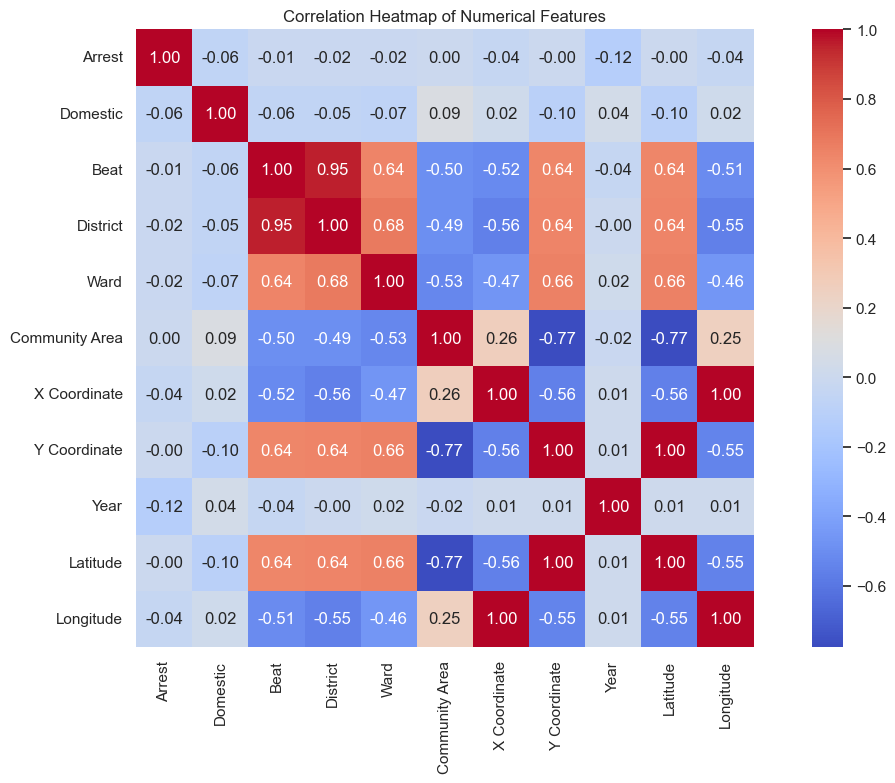

In [33]:
# Select only numeric columns
numeric_df = df_prediction.select_dtypes(include=['float64', 'int64', 'bool'])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


In [34]:
columns_to_drop = ['X Coordinate', 'Y Coordinate', 'Beat', 'Block','Location']
df_prediction = df_prediction.drop(columns_to_drop, axis=1)

def group_rare_categories(df, col, top_n=20):
    top = df[col].value_counts().nlargest(top_n).index
    return df[col].where(df[col].isin(top), other='Other')

df_prediction['Description'] = group_rare_categories(df_prediction, 'Description', top_n=30)
df_prediction['IUCR'] = group_rare_categories(df_prediction, 'IUCR', top_n=50)
df_prediction['Location Description'] = group_rare_categories(df_prediction, 'Location Description', 
                                                              top_n=30)
df_prediction['Date'] = pd.to_datetime(df['Date'])
df_prediction['Date_timestamp'] = df_prediction['Date'].astype(int)

df_prediction = df_prediction.drop(columns=['Date'])


y = df_prediction['Arrest']
X = df_prediction.drop(columns=['Arrest'])

le = LabelEncoder()
for col in ['Primary Type', 'Location Description', 'Description', 'IUCR']:
    X[col] = le.fit_transform(X[col])

# Now split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [35]:

print("Before SMOTE \n",y_train.value_counts(),"\n")

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE \n",y_train_res.value_counts())

Before SMOTE 
 Arrest
False    2139269
True      724372
Name: count, dtype: int64 

After SMOTE 
 Arrest
False    2139269
True     2139269
Name: count, dtype: int64


In [36]:
#Standardize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [37]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    print(f"\n\033[1m{model_name} Evaluation\033[0m")
    print("="*50)
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    
    if y_prob is not None:
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    


In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Arrest", "Arrest"],
                yticklabels=["No Arrest", "Arrest"])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(model, X_test_scaled, y_test, title):
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_probs = model.decision_function(X_test_scaled)
    else:
        print(f"{title} does not support ROC curve")
        return

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {title}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


Running LR Model ...
Finished Running LR Model

Logitsic Regression Evaluation
Accuracy: 0.6877
Precision: 0.4247
Recall: 0.6612
F1 Score: 0.5172
ROC AUC: 0.7040

Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.70      0.77    713090
        True       0.42      0.66      0.52    241458

    accuracy                           0.69    954548
   macro avg       0.64      0.68      0.64    954548
weighted avg       0.75      0.69      0.71    954548

Confusion Matrix:
[[496791 216299]
 [ 81812 159646]]


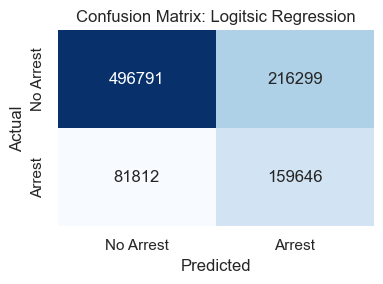

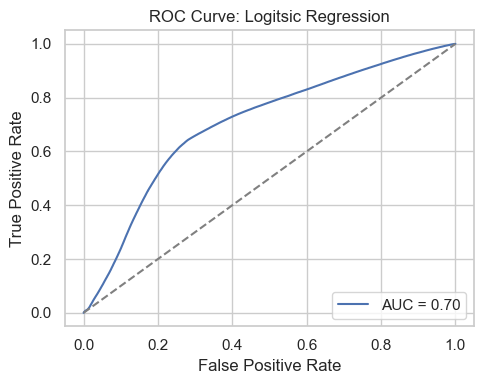

In [39]:
#Logistic Regression 
print("Running LR Model ...")
lr = LogisticRegression()
with config_context(assume_finite=True):
    lr.fit(X_train_scaled, y_train_res)
print("Finished Running LR Model")
evaluate_model(lr, X_test_scaled, y_test, "Logitsic Regression")
y_pred = lr.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred, "Logitsic Regression")
plot_roc_curve(lr, X_test_scaled, y_test,  "Logitsic Regression")

Running SVM Model ...
Finished Running SVM Model

SVM Evaluation
Accuracy: 0.6874
Precision: 0.4245
Recall: 0.6622
F1 Score: 0.5173

Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.70      0.77    713090
        True       0.42      0.66      0.52    241458

    accuracy                           0.69    954548
   macro avg       0.64      0.68      0.64    954548
weighted avg       0.75      0.69      0.71    954548

Confusion Matrix:
[[496288 216802]
 [ 81562 159896]]


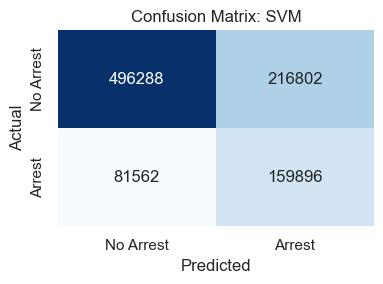

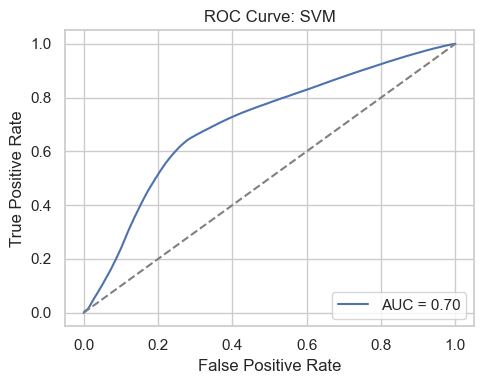

In [40]:
# SVM
print("Running SVM Model ...")
svm = LinearSVC(dual=False, max_iter=1000, random_state=42)
with config_context(assume_finite=True):
    svm.fit(X_train_scaled, y_train_res)
print("Finished Running SVM Model")
evaluate_model(svm, X_test_scaled, y_test, "SVM")
y_pred = svm.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred, "SVM")
plot_roc_curve(svm, X_test_scaled, y_test,  "SVM")

Running DT Model ...
Finished Running DT Model

Decision Tree Evaluation
Accuracy: 0.8736
Precision: 0.8071
Recall: 0.6576
F1 Score: 0.7247
ROC AUC: 0.8955

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.95      0.92    713090
        True       0.81      0.66      0.72    241458

    accuracy                           0.87    954548
   macro avg       0.85      0.80      0.82    954548
weighted avg       0.87      0.87      0.87    954548

Confusion Matrix:
[[675136  37954]
 [ 82665 158793]]


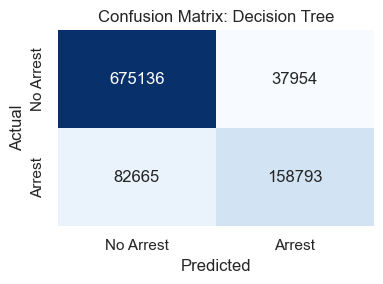

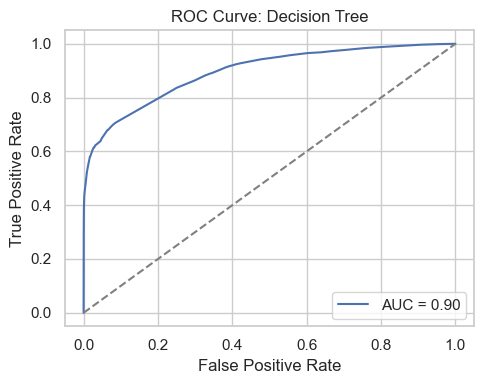

In [41]:
# Decision Tree
print("Running DT Model ...")
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5000, random_state=42)
with config_context(assume_finite=True):
    dt.fit(X_train_scaled, y_train_res)
print("Finished Running DT Model")
evaluate_model(dt, X_test_scaled, y_test, "Decision Tree")
y_pred = dt.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred, "Decision Tree")
plot_roc_curve(dt, X_test_scaled, y_test,  "Decision Tree")

Running RF Model ...
Finished Running RF Model

Random Forest Evaluation
Accuracy: 0.8692
Precision: 0.7923
Recall: 0.6543
F1 Score: 0.7167
ROC AUC: 0.8863

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.94      0.91    713090
        True       0.79      0.65      0.72    241458

    accuracy                           0.87    954548
   macro avg       0.84      0.80      0.82    954548
weighted avg       0.86      0.87      0.86    954548

Confusion Matrix:
[[671671  41419]
 [ 83467 157991]]


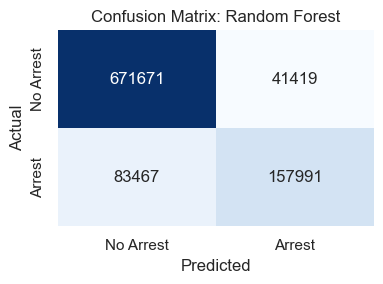

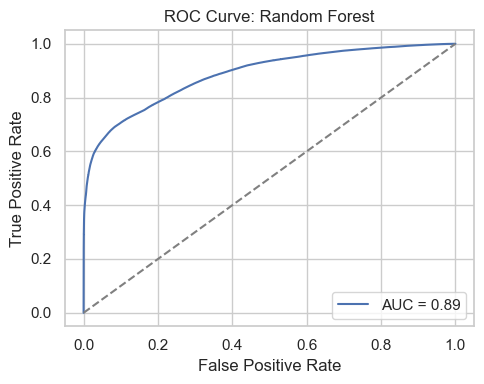

In [42]:
# Random Forest
print("Running RF Model ...")
rf = RandomForestClassifier(n_estimators=50, max_depth=10,min_samples_split=5000, 
                            n_jobs=-1, random_state=42)
with config_context(assume_finite=True):
    rf.fit(X_train_scaled, y_train_res)
print("Finished Running RF Model")
evaluate_model(rf, X_test_scaled, y_test, "Random Forest")
y_pred = rf.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred, "Random Forest")
plot_roc_curve(rf, X_test_scaled, y_test,  "Random Forest")

Running XG Model ...
Finished Running XG Model

XG-boost Evaluation
Accuracy: 0.8784
Precision: 0.8467
Recall: 0.6342
F1 Score: 0.7252
ROC AUC: 0.8994

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.96      0.92    713090
        True       0.85      0.63      0.73    241458

    accuracy                           0.88    954548
   macro avg       0.87      0.80      0.82    954548
weighted avg       0.88      0.88      0.87    954548

Confusion Matrix:
[[685363  27727]
 [ 88336 153122]]


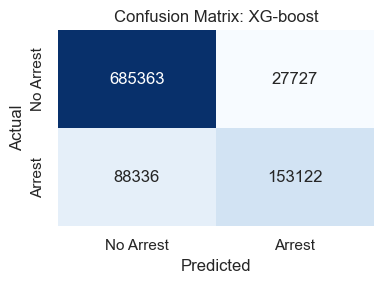

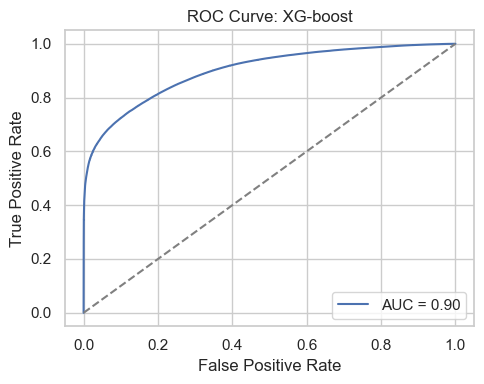

In [43]:
# XG-BOOST
print("Running XG Model ...")
xgb = XGBClassifier(tree_method='hist', max_depth=6, n_estimators=100, learning_rate=0.1, 
                    n_jobs=-1, random_state=42)
with config_context(assume_finite=True):
    xgb.fit(X_train_scaled, y_train_res)
print("Finished Running XG Model")
evaluate_model(xgb, X_test_scaled, y_test, "XG-boost")
y_pred = xgb.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred, "XG-boost")
plot_roc_curve(xgb, X_test_scaled, y_test,  "XG-boost")

Running PERC Model ...
Finished Running PERC Model

Percepton Evaluation
Accuracy: 0.5598
Precision: 0.3270
Recall: 0.6996
F1 Score: 0.4457

Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.51      0.63    713090
        True       0.33      0.70      0.45    241458

    accuracy                           0.56    954548
   macro avg       0.58      0.61      0.54    954548
weighted avg       0.71      0.56      0.59    954548

Confusion Matrix:
[[365435 347655]
 [ 72537 168921]]


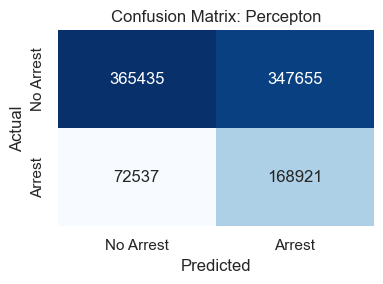

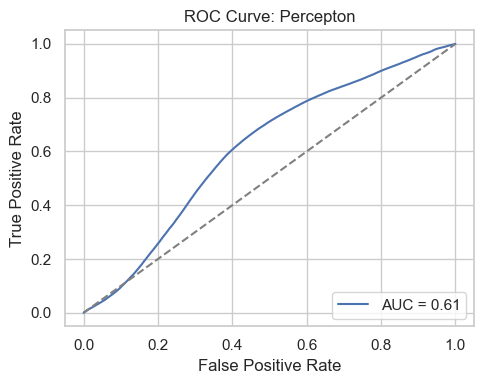

In [44]:
#Percepton
print("Running PERC Model ...")
perc = Perceptron()
with config_context(assume_finite=True):
    perc.fit(X_train_scaled, y_train_res)
print("Finished Running PERC Model")
evaluate_model(perc, X_test_scaled, y_test, "Percepton")
y_pred = perc.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred, "Percepton")
plot_roc_curve(perc, X_test_scaled, y_test,  "Percepton")


Running MLP Model ...
Finished Running MLP Model

Multi-Layer Percepton Evaluation
Accuracy: 0.8704
Precision: 0.8075
Recall: 0.6401
F1 Score: 0.7141
ROC AUC: 0.8902

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.95      0.92    713090
        True       0.81      0.64      0.71    241458

    accuracy                           0.87    954548
   macro avg       0.85      0.79      0.82    954548
weighted avg       0.87      0.87      0.87    954548

Confusion Matrix:
[[676254  36836]
 [ 86907 154551]]


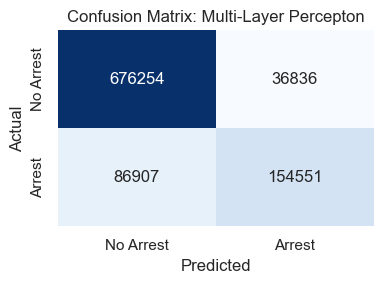

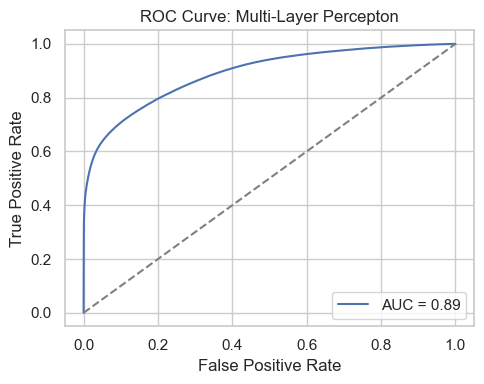

In [45]:
# Multilayer percepton
print("Running MLP Model ...")
mlp = MLPClassifier(hidden_layer_sizes=(100,), early_stopping=True, batch_size=1024,random_state=42)
with config_context(assume_finite=True):
    mlp.fit(X_train_scaled, y_train_res)
print("Finished Running MLP Model")
evaluate_model(mlp, X_test_scaled, y_test, "Multi-Layer Percepton")
y_pred = mlp.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred, "Multi-Layer Percepton")
plot_roc_curve(mlp, X_test_scaled, y_test,  "Multi-Layer Percepton")

In [46]:
# def evaluate_model(model, X_test, y_test, model_name):
#     start_time = time.time()
#     y_pred = model.predict(X_test)
#     y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
#     print(f"\n\033[1m{model_name} Evaluation\033[0m")
#     print("="*50)
    
#     # Basic metrics
#     print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
#     print(f"Precision: {precision_score(y_test, y_pred):.4f}")
#     print(f"Recall: {recall_score(y_test, y_pred):.4f}")
#     print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    
#     # ROC-AUC if available
#     if y_prob is not None:
#         print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    
#     # Classification report
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred))
    
#     # Confusion matrix
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_test, y_pred))
    
#     print(f"\nEvaluation time: {time.time() - start_time:.2f} seconds")

# # List of models you've trained
# models = [
#     ('Logistic Regression', lr),
#     ('Decision Tree', dt),
#     ('Random Forest', rf),
#     ('XGBoost', xgb),
#     # ('SVM', svm),  # Only include if you've trained SVM
#     # ('MLP', mlp)   # Only include if you've trained MLP
# ]

# # Evaluate all models
# for name, model in models:
#     evaluate_model(model, X_test_scaled, y_test, name)

Beginning with an evaluation of each model's performance, the Logistic Regression model, while computationally efficient with an evaluation time of 1.31 seconds, demonstrates the weakest performance overall. It achieves an accuracy of only 0.6858, a precision of 0.4236, and a recall of 0.6621 for the positive class, resulting in a modest F1-score of 0.5167 and an ROC AUC of 0.7032. Its confusion matrix reveals a significant number of false positives (176,125) and false negatives (66,075), indicating a high rate of misclassification. This model, due to its linear nature, likely struggles to capture the underlying complex, non-linear relationships within the data.

The Decision Tree model shows a substantial improvement in performance, boasting an accuracy of 0.8765, precision of 0.8232, recall of 0.6535, and a strong F1-score of 0.7286. Its ROC AUC of 0.8966 highlights its excellent discriminative power. With an evaluation time of 1.15 seconds, it's also the fastest among the more accurate models. The confusion matrix for the Decision Tree indicates a significantly reduced number of false positives (27,446) compared to Logistic Regression, although its false negatives (67,748) are similar. Its strength lies in its ability to model non-linear relationships and provide interpretable decision rules, though it is prone to overfitting if not properly pruned.

The Random Forest model delivers solid performance, achieving an accuracy of 0.8652, precision of 0.7682, recall of 0.6710, and an F1-score of 0.7163. Its ROC AUC is 0.8847. While its performance is strong, it's slightly outperformed by the Decision Tree in terms of overall accuracy and precision. The evaluation time for Random Forest is the longest at 1.67 seconds, likely due to its ensemble nature of building multiple decision trees. Its confusion matrix shows 39,597 false positives and 64,329 false negatives, placing it between Logistic Regression and the Decision Tree in terms of misclassifications. Random Forests generally offer good generalization and handle overfitting better than single decision trees.

Finally, the XGBoost model emerges as the top contender. It achieves the highest accuracy of 0.8793 and the best ROC AUC of 0.8993. Its precision for the positive class is also the highest at 0.8536, although its recall is slightly lower at 0.6328, leading to an F1-score of 0.7268. The evaluation time for XGBoost is 1.45 seconds, which is efficient for its performance level. The confusion matrix demonstrates the fewest false positives (21,219) among all models, with 71,803 false negatives. XGBoost's strength lies in its boosted ensemble approach, iteratively correcting errors of previous models and incorporating regularization to prevent overfitting.

Comparing these results, it's clear that the ensemble methods (Decision Tree, Random Forest, and XGBoost) significantly outperform the simpler Logistic Regression model. The Decision Tree offers a good balance of performance and speed, and its interpretability is a key advantage. Random Forest improves upon the single Decision Tree by reducing overfitting, but in this specific case, its metrics are slightly below the Decision Tree's and XGBoost's. XGBoost consistently shows the highest overall performance, particularly in accuracy and its ability to minimize false positives, which is often crucial in classification tasks where identifying true positives with high confidence is paramount. While its recall is marginally lower than Logistic Regression's and Random Forest's, its superior precision and ROC AUC suggest that it is more reliable when making positive predictions.

Given these detailed evaluations, **XGBoost is the chosen model** for this task. The justification for this choice stems from its superior overall accuracy, its leading ROC AUC score, and its remarkable precision in identifying positive instances. While its recall is not the absolute highest, the significant reduction in false positives is a critical advantage, implying that when XGBoost predicts a positive outcome, it is highly reliable. This trade-off between precision and recall, where precision is prioritized, is often desirable in many real-world applications where false positives can be more costly or problematic than false negatives. Furthermore, its efficient evaluation time, despite its complexity as a gradient boosting algorithm, makes it a practical and performant choice for deployment, demonstrating its ability to learn complex patterns effectively while maintaining robust generalization.

In [47]:
# def plot_confusion_matrix(y_true, y_pred, title):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(4, 3))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=["No Arrest", "Arrest"],
#                 yticklabels=["No Arrest", "Arrest"])
#     plt.title(f"Confusion Matrix: {title}")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.tight_layout()
#     plt.show()

# def plot_roc_curve(model, X_test_scaled, y_test, title):
#     if hasattr(model, "predict_proba"):
#         y_probs = model.predict_proba(X_test_scaled)[:, 1]
#     elif hasattr(model, "decision_function"):
#         y_probs = model.decision_function(X_test_scaled)
#     else:
#         print(f"{title} does not support ROC curve")
#         return

#     fpr, tpr, _ = roc_curve(y_test, y_probs)
#     roc_auc = auc(fpr, tpr)

#     plt.figure(figsize=(5, 4))
#     plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
#     plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title(f"ROC Curve: {title}")
#     plt.legend(loc="lower right")
#     plt.tight_layout()
#     plt.show()


In [48]:
# models = [lr, svm, dt, rf, xgb, perc, mlp]
# model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost', 'Perceptron', 'MLP']

# for model, name in zip(models, model_names):
#     print(f"\n==== {name} ====")
#     y_pred = model.predict(X_test_scaled)
#     plot_confusion_matrix(y_test, y_pred, name)
#     plot_roc_curve(model, X_test_scaled, y_test, name)
